In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

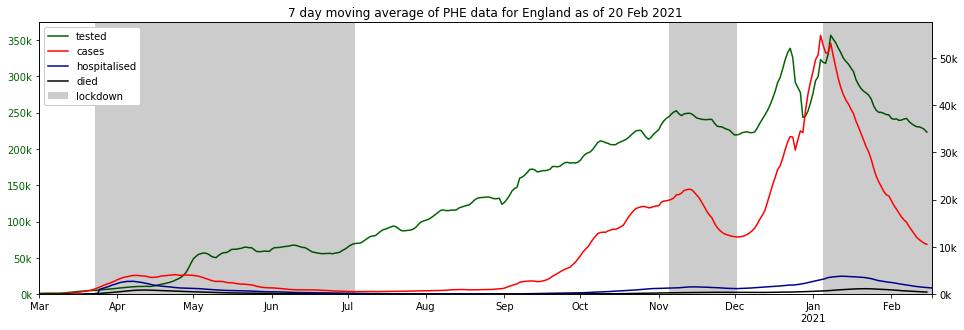

In [2]:
plot_summary(earliest_date='2020-03-01')

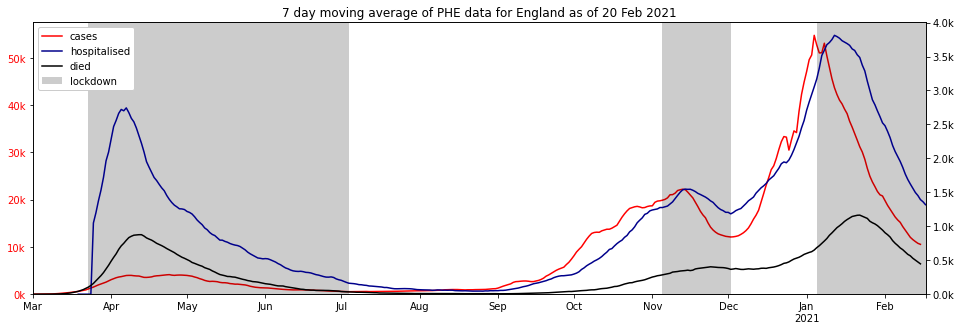

In [3]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,508657.0,14537978.0,14029321.0,56286961,0.903685,24.924638,74.171677
1,Northern Ireland,N92000002,30753.0,442917.0,412164.0,1893667,1.623992,21.765390,76.610618
2,Scotland,S92000003,33473.0,1412643.0,1379170.0,5463300,0.612688,25.244266,74.143045
3,Wales,W92000004,32002.0,853904.0,821902.0,3152879,1.015009,26.068301,72.916690


'partial: 17,247,442'

'full: 604,885'

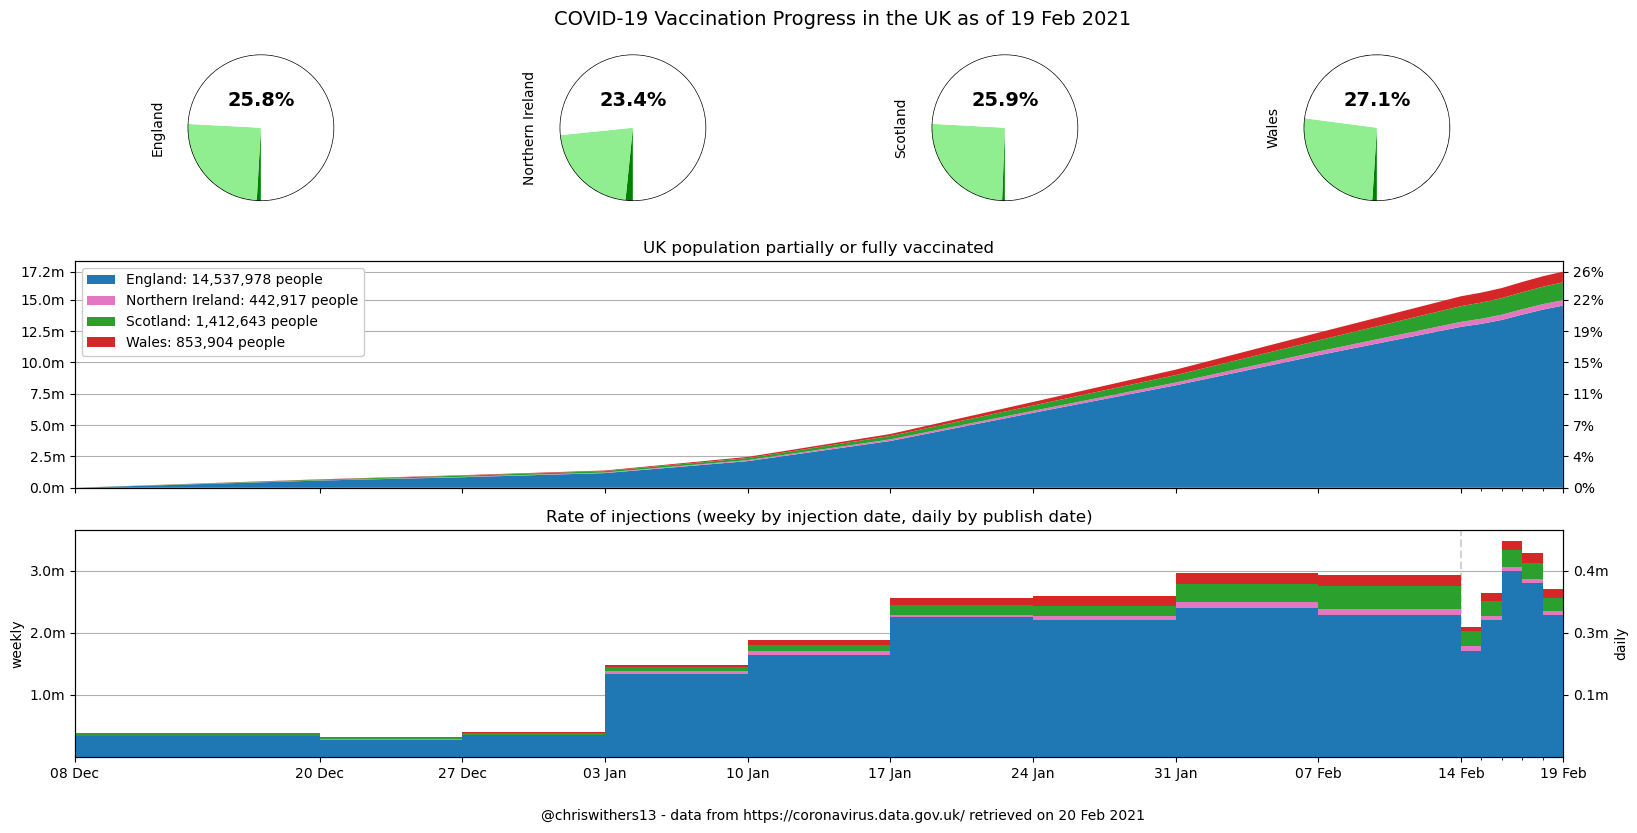

In [4]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (Total),Complete (New),First Dose (Total),cumPeopleVaccinatedSecondDoseByPublishDate,Complete (Total)
,,,,,,,
England,19 Feb 21,"+323,802","+3,895","+3,895","+14,537,978","+508,657","+508,657"
Northern Ireland,19 Feb 21,"+6,774",+372,+372,"+442,917","+30,753","+30,753"
Scotland,19 Feb 21,"+26,491","+4,458","+4,458","+1,412,643","+33,473","+33,473"
Wales,19 Feb 21,"+14,839","+6,569","+6,569","+853,904","+32,002","+32,002"


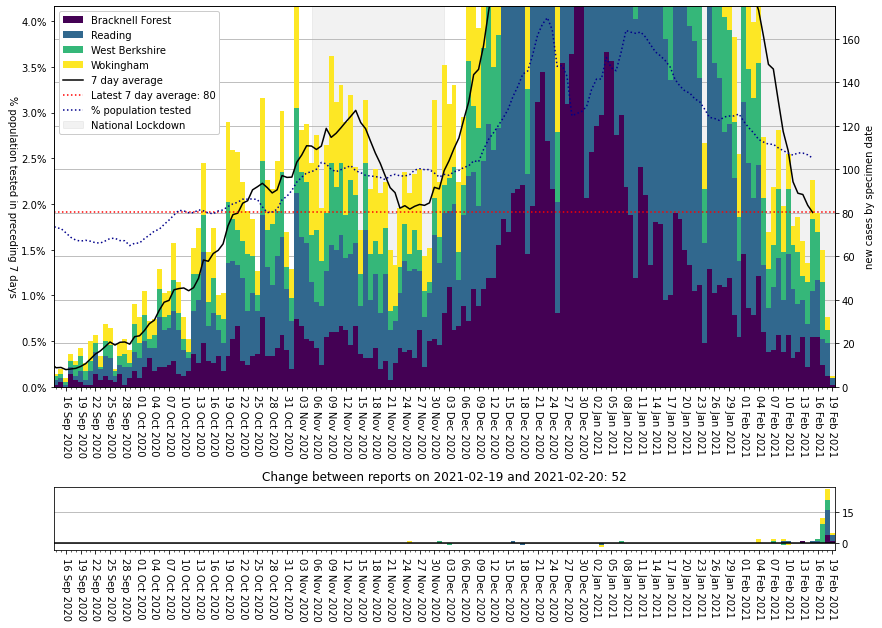

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=175)

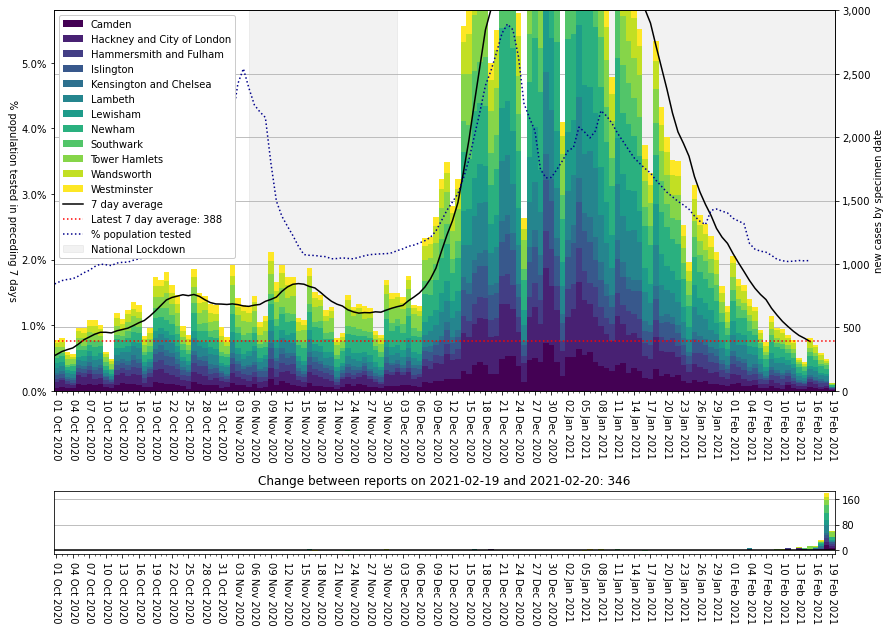

In [7]:
plot_areas(for_date, areas=london_areas, ylim=3_000)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [26]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,300.479105,217.0,2021-02-19
E06000002,Middlesbrough,238.331678,336.0,2021-02-19
E06000031,Peterborough,238.308308,482.0,2021-02-19
E06000017,Rutland,225.411376,90.0,2021-02-19
E06000016,Leicester,216.529654,767.0,2021-02-19
E08000028,Sandwell,215.253463,707.0,2021-02-19
E07000170,Ashfield,211.854469,271.0,2021-02-19
E07000218,North Warwickshire,200.723216,131.0,2021-02-19
E07000199,Tamworth,199.488891,153.0,2021-02-19


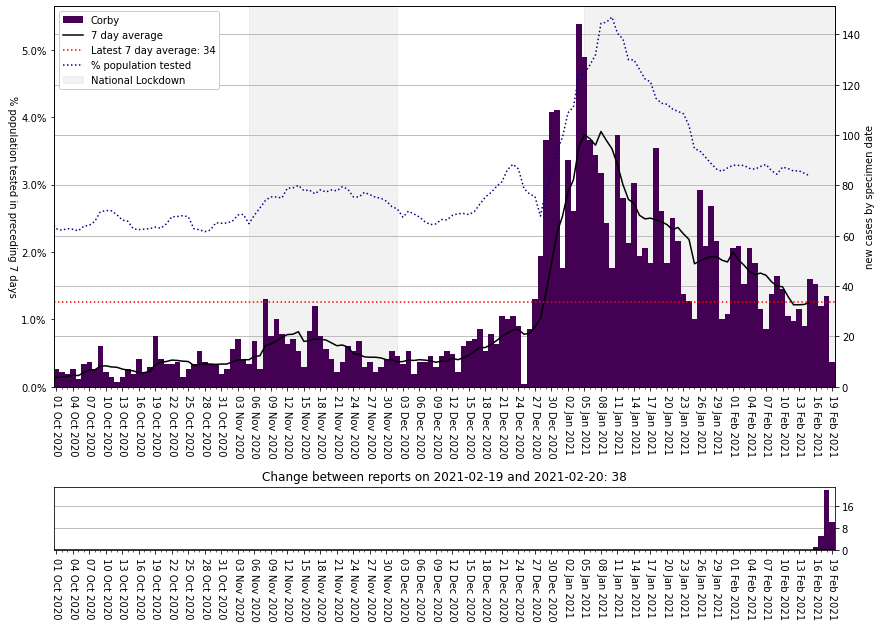

In [27]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [28]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,141.441353,1615.0,2021-02-19
E08000035,Leeds,135.663484,1076.0,2021-02-19
E08000032,Bradford,176.369457,952.0,2021-02-19
E08000003,Manchester,143.436470,793.0,2021-02-19
E06000016,Leicester,216.529654,767.0,2021-02-19
S12000049,Glasgow City,117.355320,743.0,2021-02-19
E08000028,Sandwell,215.253463,707.0,2021-02-19
E08000034,Kirklees,153.710774,676.0,2021-02-19
E08000012,Liverpool,134.125234,668.0,2021-02-19


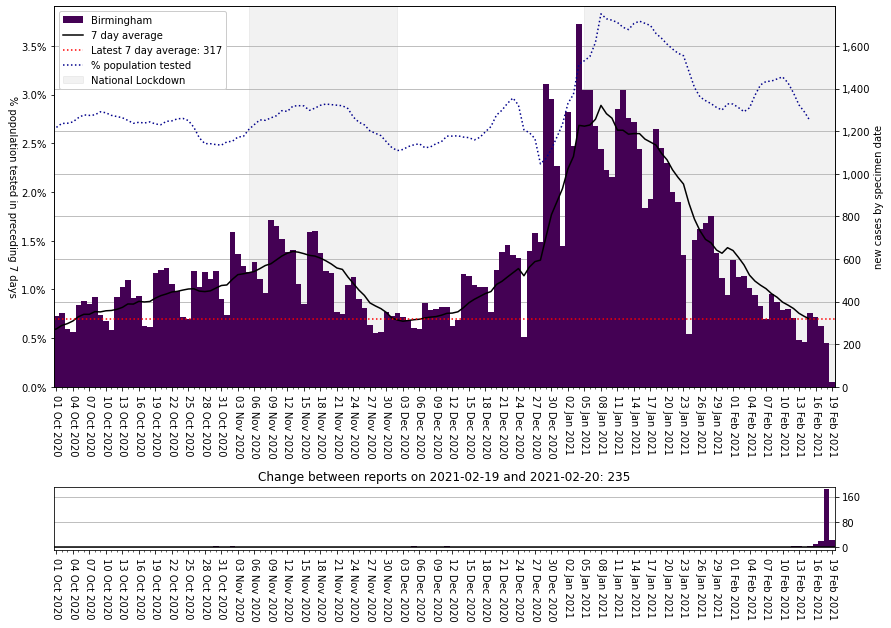

In [29]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [30]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.6
phe_max = 0.35

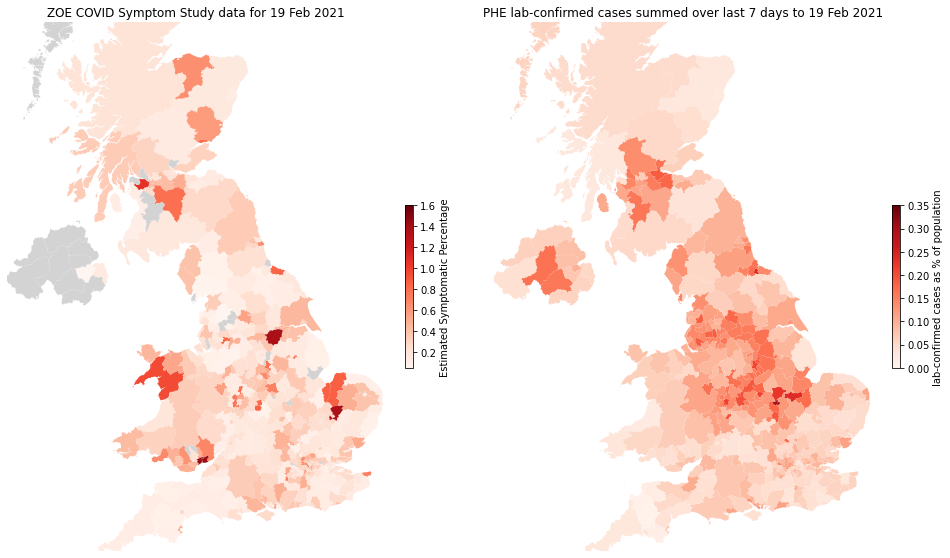

In [31]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [32]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

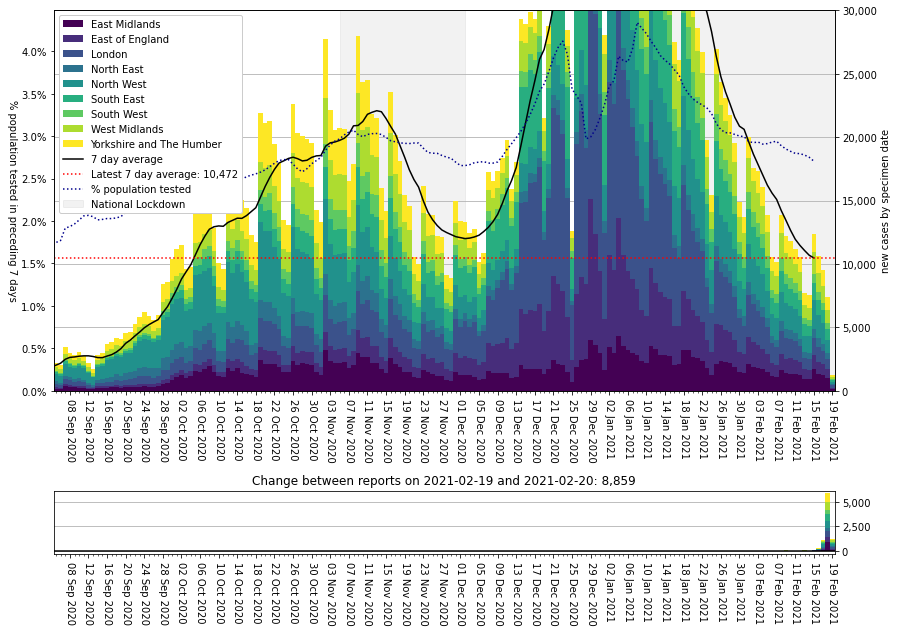

In [33]:
plot_areas(for_date, area_type=region, ylim=30_000, earliest='2020-09-05')

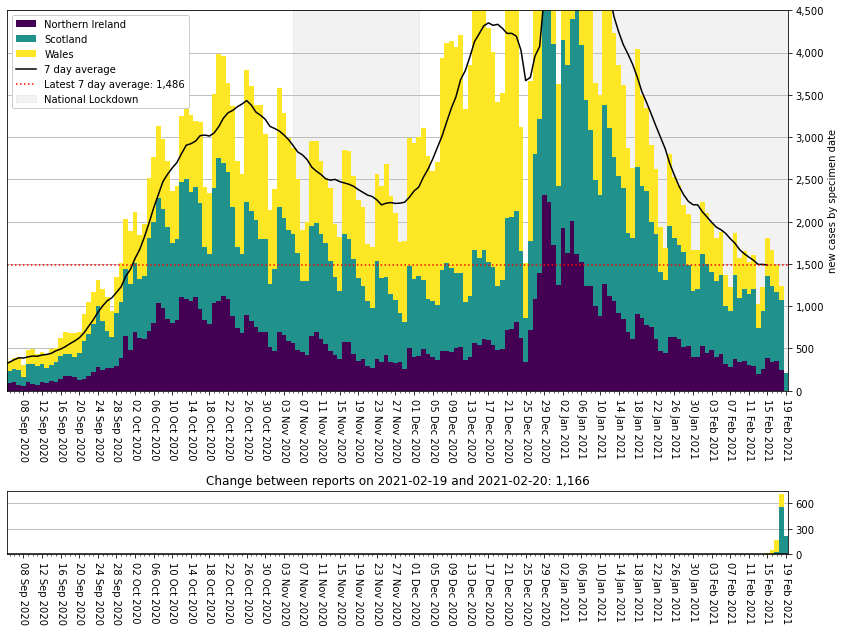

In [34]:
plot_areas(for_date, 'cases_devolved', ylim=4_500, diff_ylims=None, earliest='2020-09-05')